In [69]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import wavfile
import scipy
import stft
import pandas as pd
from scipy.signal import blackman
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from time import perf_counter
from datetime import datetime
from sklearn.neighbors import KNeighborsRegressor

In [4]:
%matplotlib inline

First, let's load some audio

In [5]:
rate, data = wavfile.read('04-LightField.wav')

/Users/georgeoblapenko/anaconda/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Next, we'll compute a spectrogram of a mono signal (obtained by summing the L & R channels) and using the default (cosine) window function

In [6]:
overlap = 4
framelength = 1024

specgram = stft.spectrogram((data[:, 1] + data[:, 0]), framelength=framelength, overlap=overlap)

We're interested in the absolute values of the spectrogram, and we'll log-scale it

In [7]:
log_spectrogram = np.log(1 + scipy.absolute(specgram))  # X axis - frequency bins, Y axis - time
phase = np.angle(specgram)
print(log_spectrogram.shape)

(513, 85845)


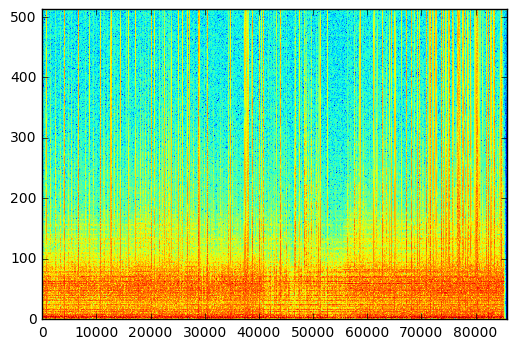

In [8]:
plt.imshow(log_spectrogram, origin='lower', aspect='auto',
           interpolation='nearest')

Now we'll specify for each moment of time `t` which preceding intervals of the form `[t-a,t-b]` we want to use for feature extraction. So if for each interval we have `N` different features, the total amount of different features we'll have is equal to `N * n_intervals`.

We want to have varied information from the audio, so we sample features not for every frame, but each `step_size` frames.

In [42]:
steps = [(-3000, 0), (-2000, 0), (-1000, 0), (-500, 0), (-250, 0), (-100, 0), (-50, 0), (-25, 0), (-10, 0), (-6, 0)]
min_offset = max([-(i[0]) for i in steps])
step_size = 3

In [43]:
min_offset

3000

We want to have the frequency content of an interval as a (vector) feature; but we have too many frequency bins, so we just reduce their number by summation of their content.

In [44]:
freq_avg_step = 9
num_freq_bins_reduced = log_spectrogram.shape[0]//freq_avg_step
print(num_freq_bins_reduced)

freq_avg_step_large = 57
num_freq_bins_reduced_large = log_spectrogram.shape[0]//freq_avg_step_large
print(num_freq_bins_reduced_large)

57
9


Some feature extraction functions

In [45]:
def get_max_amplitude(spgram_slice):
    return np.max(spgram_slice)

In [46]:
def get_min_amplitude(spgram_slice):
    return np.max(spgram_slice)

In [47]:
def get_amplitude_change2(spgram_slice):
    a = np.sum(spgram_slice[:, :spgram_slice.shape[1]//2]) - np.sum(spgram_slice[:, spgram_slice.shape[1]//2:])
    return a / spgram_slice.shape[1]

In [48]:
def get_avg_amplitude(spgram_slice):
    return np.sum(spgram_slice) / spgram_slice.shape[1]  # get sum of amplitudes of the slice

In [49]:
def get_median_amplitude(spgram_slice):
    return np.median(spgram_slice)

In [50]:
def get_loudest_bins(spgram_slice):
    tmp = np.sum(spgram_slice, axis=1)
    return np.argpartition(tmp, -N_loudest_bins_to_get)[-N_loudest_bins_to_get:]

Now we let's extract the features and the spectral content for each frame

In [51]:
feature_list = [get_max_amplitude, get_min_amplitude,
                get_avg_amplitude, get_amplitude_change2, get_median_amplitude]
N_loudest_bins_to_get = 10
N_prev_frames = 10

get_slice_freq_bins = True
# get_slice_freq_bins = False  # if true, we take mean of enlarged frequency bin over a slice

freq_bin_feature_list = [get_max_amplitude, get_min_amplitude,
                         get_avg_amplitude]

In [52]:
nfeat = len(feature_list) * len(steps) + num_freq_bins_reduced * N_prev_frames + N_loudest_bins_to_get * len(steps)
if get_slice_freq_bins:
    nfeat += len(steps) * num_freq_bins_reduced
nfeat += len(freq_bin_feature_list) * len(steps) * num_freq_bins_reduced_large
# number of features - we have several scalar features for each slice of audio

print(nfeat)

1560


In [53]:
def get_features_for_frame(log_spgram_slice, scalar_functions, n_features):
    res = np.zeros(n_features)
    counter = 0
    for slicing in steps:
        for s_f in scalar_functions:
            res[counter] = s_f(log_spgram_slice[:, min_offset + slicing[0]:min_offset + slicing[1]])
            counter += 1
        if N_loudest_bins_to_get > 0:
            res[counter:counter+N_loudest_bins_to_get] = get_loudest_bins(log_spgram_slice[:, min_offset + slicing[0]:min_offset + slicing[1]])
            counter += N_loudest_bins_to_get
    res[counter:counter+num_freq_bins_reduced * N_prev_frames] = log_spgram_slice[::freq_avg_step, -1-N_prev_frames:-1].flatten()
    counter += num_freq_bins_reduced * N_prev_frames
    if get_slice_freq_bins:
        for slicing in steps:
            res[counter:counter+num_freq_bins_reduced] = np.mean(log_spgram_slice[::freq_avg_step, min_offset + slicing[0]:min_offset + slicing[1]],axis=1).flatten()
            counter += num_freq_bins_reduced
    for slicing in steps:
        for s_f in freq_bin_feature_list:
            for i in range(num_freq_bins_reduced_large):
                res[counter] = s_f(log_spgram_slice[freq_avg_step*i:freq_avg_step_large*(i+1),
                                                    min_offset + slicing[0]:min_offset + slicing[1]])
                counter += 1
    return res

In [61]:
def get_feature_names():
    res = []
    for slicing in steps:
        for s_f in feature_list:
            name = s_f.__name__[4:] + '_'
            name += str(slicing[0]) + '_' + str(slicing[1])
            res.append(name)
        for bin_no in range(N_loudest_bins_to_get):
            res.append('loudest_bin_' + str(bin_no))
    for i in range(num_freq_bins_reduced * N_prev_frames):
        res.append('prev_frames_flattened_' + str(i))
    if get_slice_freq_bins:
        for slicing in steps:
            for i in range(num_freq_bins_reduced):
                name = 'freq_binr_' + str(i) + '_mean_'
                name += str(slicing[0]) + '_' + str(slicing[1])
                res.append(name)
    for slicing in steps:
        for s_f in freq_bin_feature_list:
            for i in range(num_freq_bins_reduced_large):
                name = 'freq_binr_' + str(i) + '_' + s_f.__name__[4:] + '_'
                name += str(slicing[0]) + '_' + str(slicing[1])
                res.append(name)
    return res

In [62]:
def process_spectrogram(log_spgram, scalar_functions, n_slices, n_features):
    # features, frequency content - X, Y
    # n_slices - the number of data points
    loc_Y = np.zeros([n_slices, log_spgram.shape[0]])
    loc_X = np.zeros([n_slices, n_features])
    for i in range(n_slices):
        if i%200 == 0:
            print(i)
        loc_Y[i] = log_spgram[:, min_offset + step_size * i]
        loc_X[i, 0:n_features] = get_features_for_frame(log_spgram[:,step_size * i:min_offset
                                                                     + step_size * i], scalar_functions, n_features)
    return [loc_X, loc_Y]

In [63]:
n_samples = 10000

start_time = perf_counter()
X, Y = process_spectrogram(log_spectrogram, feature_list,
                           n_samples, nfeat)
print(perf_counter() - start_time)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800
937.6764306059999


And now we write the features, along with the target data, to a file

In [81]:
index_array = [min_offset + i * step_size for i in range(n_samples)]

df = pd.DataFrame({'timestep' : index_array})

feature_names = get_feature_names()
for i, f_n in enumerate(feature_names):
    df[f_n] = X[:, i]

curr_time = datetime.now()
curr_t_str = str(curr_time.year) + '_' + str(curr_time.month) + '_' + str(curr_time.day) + '_' + str(curr_time.hour)

audio_name = 'branca10k_step3_' + curr_t_str
    
df.to_csv('data/' + audio_name + '_features.csv', index=False)


df = pd.DataFrame({'timestep' : index_array})

for i in range(log_spectrogram.shape[0]):
    df['freqbin_' + str(i)] = Y[:, i]

audio_name = 'branca10k_step3_' + curr_t_str
    
df.to_csv('data/' + audio_name + '_target.csv', index=False)

Next, we scale the features and the target values

In [82]:
feature_scaler_freq = StandardScaler()
X = feature_scaler_freq.fit_transform(X)

freq_Y_mean = np.mean(Y)
freq_Y_std = np.std(Y)

Y = (Y - freq_Y_mean) / freq_Y_std

Then, we train a tree-based predictor for each frequency band

In [83]:
predictors = []
start_time = perf_counter()
for i in range(Y.shape[1]):
#     predictor = KNeighborsRegressor(n_neighbors=3)
    predictor = DecisionTreeRegressor(max_depth=15)
#     predictor = CatBoostRegressor(iterations=3, depth=6, learning_rate=0.1, loss_function='RMSE')
#     predictor = XGBRegressor(n_estimators=2)
    if i%50 == 0:
        print(i)
    predictor.fit(X, Y[:, i])
    predictors.append(predictor)
print(perf_counter() - start_time)

0
50
100
150
200
250
300
350
400
450
500
8671.500502183


Let's then try and generate some new audio (frequency and phase) and compare it with the real audio, to assess the performance of our model. First, we'll take a chunk of the audio that hasn't been fed to our model before, to use a starting point.
At some point, the model will only generate audio based on only newly generated audio.

In [94]:
# rate, data = wavfile.read('01-18_Pulses.wav')
# overlap = 4
# framelength = 1024

# specgram = stft.spectrogram((data[:, 1] + data[:, 0]), framelength=framelength, overlap=overlap)
# log_spectrogram = np.log(1 + scipy.absolute(specgram))  # X axis - frequency bins, Y axis - time
# in case we want to use something other as the seed audio, we load a new wav-file here

In [95]:
keep_starting_audio = False  # if False, we cut off the seed audio
gen_start = min_offset + n_samples * step_size
print(gen_start, min_offset)  # the starting point of the seed audio and the length of the seed audio
generate_size = 5000  # how many samples we want to generate
result = np.zeros([log_spectrogram.shape[0], generate_size + min_offset])
result_phase = np.random.rand(log_spectrogram.shape[0], generate_size + min_offset) * 2 * 3.141
feat_arr = np.zeros([1, nfeat])

for i in range(min_offset):
    result[:, i] = log_spectrogram[:, gen_start + i]
start_time = perf_counter()
for i in range(generate_size):
    if i%500 == 0:
        print(i)
    feat_arr[0,:nfeat] = get_features_for_frame(result[:, i:i+min_offset],
                                                feature_list, nfeat)
    for j in range(Y.shape[1]):
        result[j, min_offset+i] = predictors[j].predict(feature_scaler_freq.transform(feat_arr))
        result[j, min_offset+i] *= freq_Y_std  # now we rescale it back
        result[j, min_offset+i] += freq_Y_mean
print(perf_counter() - start_time)

3000 3000
0
500
1000
1500
2000
2500
3000
3500
4000
4500
591.3798480910009


In [96]:
print(mean_squared_error(result[:, min_offset:],
                         log_spectrogram[:, gen_start + min_offset:gen_start + min_offset + generate_size]))

8.00393901819


In [97]:
result.shape

(513, 8000)

In [98]:
if not keep_starting_audio:
    result = result[:, min_offset:]
    result_phase = result_phase[:, min_offset:]

Let's now generate some audio based on an audio 'seed' (in this case, a chunk of the original waveform).
At some point, the model will only generate audio based on only newly generated audio.

In [99]:
np.max(result)

14.888402551796094

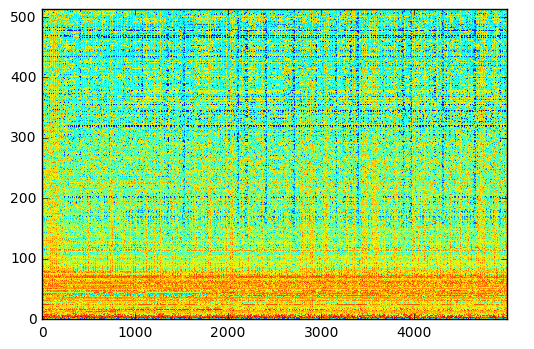

In [100]:
plt.imshow(result, origin='lower', aspect='auto',
           interpolation='nearest')

In [101]:
freq_amplitude = np.exp(result) - 1
result_complex = freq_amplitude * np.exp(1j * result_phase)

In [102]:
audio_dat = stft.ispectrogram(result_complex, framelength=framelength, overlap=overlap)

In [103]:
def write_stereo(a_l, a_r, s_r, name):
    a_s = np.zeros([a_l.shape[0], 2], dtype=np.int16)
    a_s[:, 0] = a_l
    a_s[:, 1] = a_r
    print(a_s.shape)
    wavfile.write(name, s_r, a_s)

In [104]:
write_stereo(audio_dat, audio_dat, 44100, 'branca_learn_genreich_10loudest_d15_10k.wav')

(1279744, 2)


In [ ]:
# Schoenberg – 3.5047782083
# Reich - 1.47755376083
# (-3000, 0), (-2000, 0), (-1000, 0), (-500, 0), (-250, 0), (-100, 0), (-50, 0), (-25, 0), (-6, 0)